### FasterRCNN

In this tutorial, we will apply region based object detection model, FasterRCNN, to detect object in sky survey images.


Exercises

- Explore FasterRCNN model

- load dataset

- train the model

- make predictions and evaulation


In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
cd '/drive/MyDrive/04_le/'

/drive/MyDrive/ztf_demo


In [ ]:
!pip install torch==2.1 torchvision==0.16
# com https://github.com/pytorch/vision

# due to incompatible issues, we need to downgrade pytorch to 2.1 and torchvision to 0.16

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoade
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from PIL import Image

In [ ]:
torch.__version__, torchvision.__version__

('2.1.0+cu121', '0.16.0+cu121')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### explore model

We will load the pretrained model on the COCO datasets from torchvision

The FasterRCNN model has three major parts
- backbone: feature extraction
- rpn: region proposal network,
- roi_head: classification and bounding box regression

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 188MB/s]


In [ ]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [ ]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [ ]:
model.to(device)

### eval mode

eval mode, the model take list of images as input, and predict class and

In [ ]:
model.eval()

In [ ]:
x = torch.rand(3, 300, 400)
x = x.to(device)
#x = x.unsqueeze(0)
x.shape

torch.Size([3, 300, 400])

In [ ]:
predictions = model([x])

In [ ]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

### train mode

train mode, the model images and targets as input, and output loss

FasterRCNN contains 4 loss
- loss_objectness
- loss_rpn_box_reg
- loss_classifier
- loss_box_reg


In [ ]:
model.train()

In [ ]:

# 4 images, each image has 11 boxes [x1, y1, x2, y2]; label
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)

boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))



In [ ]:
images.shape, labels

(torch.Size([4, 3, 600, 1200]),
 tensor([[44, 42, 57,  7, 14, 60, 67, 14, 77, 75,  5],
         [71, 55, 77, 17, 64, 15,  3, 56, 10, 87,  6],
         [68, 13, 44, 43, 83, 67, 59, 58, 33, 49, 85],
         [73, 41, 75, 64, 65, 14, 32, 22, 39, 58, 65]]))

In [ ]:
images = list(image.to(device) for image in images)

targets = []

for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i].to(device)
    d['labels'] = labels[i].to(device)
    targets.append(d)


In [ ]:
type(images), images[0].shape, len(images)

(list, torch.Size([3, 600, 1200]), 4)

In [ ]:
type(targets), targets[0], len(targets)

(list,
 {'boxes': tensor([[0.7582, 0.3984, 1.5930, 1.1735],
          [0.7019, 0.2871, 1.5962, 0.9648],
          [0.2016, 0.9763, 0.2136, 1.6076],
          [0.8022, 0.1748, 1.6635, 0.7307],
          [0.5341, 0.6472, 0.8492, 0.8059],
          [0.0949, 0.9896, 0.0972, 1.0603],
          [0.8326, 0.1227, 1.4752, 0.8958],
          [0.6549, 0.1756, 0.7539, 0.3187],
          [0.8412, 0.6616, 1.3336, 1.5359],
          [0.0475, 0.2360, 0.7045, 0.6099],
          [0.0248, 0.5127, 0.9301, 1.1819]], device='cuda:0'),
  'labels': tensor([35, 67, 47, 45, 36, 65, 69, 32,  3,  4, 48], device='cuda:0')},
 4)

In [ ]:
# in train mode

output = model(images, targets)

In [ ]:
######
#output loss

output


{'loss_classifier': tensor(0.3812, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0280, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(2.0772, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(1.1220, device='cuda:0', grad_fn=<DivBackward0>)}

### load dataset

In [ ]:
class LEDataset(torch.utils.data.Dataset):
    def __init__(self, annot_path='./dataset/rcnn/LE_train.txt',
                        transform=None):

        self.ann = self.get_annot(annot_path=annot_path)
        self.imgfiles = list( self.ann.keys() )
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.imgfiles[idx]
        img = Image.open(img_path).convert("RGB")

        img = self.transform(img).to(device)

        box_labels  = self.ann[img_path]
        target = {}
        target['boxes'] = torch.from_numpy(box_labels[:, :4]).to(device)
        target['labels'] = torch.from_numpy(box_labels[:, 4] + 1, ).to(torch.int64).to(device)
        return img, target

    def get_annot(self, annot_path = 'train.txt'):
        """get annotation from dataset text"""
        with open(annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        resdic = {}
        for ann in annotations:
            ann = ann.split(' ')
            image_path = ann[0]
            boxarr = []
            for a in ann[1:]:
                box = np.fromstring(a, sep=',')
                boxarr.append(box)
            boxarr = np.array(boxarr)
            resdic[image_path] = boxarr

        return resdic

    def __len__(self):
        return len(self.imgfiles)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
    ])


In [ ]:
leData = LEDataset(annot_path='./dataset/rcnn/LE_train.txt',
                   transform=transform)

data_loader = torch.utils.data.DataLoader(leData, batch_size=2, shuffle=True,
                                          collate_fn=lambda x: tuple(zip(*x)))



In [ ]:
len(data_loader)

4

In [ ]:
imgs, targets = next(iter(data_loader))

In [ ]:
targets[0]['labels']

tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0')

In [ ]:
output = model(imgs, targets)

In [ ]:
output

{'loss_classifier': tensor(0.8272, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.2275, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.9507, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0595, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)}

### plot boxes

In [ ]:
Colors = {1:'indianred', 2: 'steelblue'}

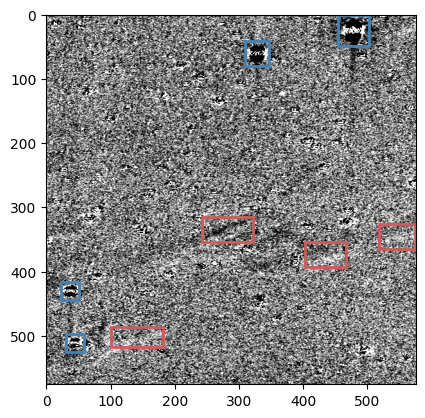

In [ ]:
fig, ax = plt.subplots(1, 1)

idx = 1

img = imgs[idx].cpu().numpy();
target = targets[idx]

ax.imshow(img[0, :,:], cmap='gray', )
for i in range(len(target['labels'])):
    xmin, ymin, xmax, ymax = target['boxes'][i].cpu().numpy()
    label = int(target['labels'][i].cpu())
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                    fill=False, color=Colors[label], linewidth=2)

    ax.add_patch(rect)


### train the model

In [ ]:
model.train();


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)



In [ ]:
num_epochs = 20
loss_run = []

for epoch in range(num_epochs):
    for images, targets in data_loader:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_run.append(losses.item())
        print(f'epoch {epoch}, loss {losses}')


epoch 0, loss 0.7782006824818192
epoch 0, loss 0.8057122140472799
epoch 0, loss 1.0253931008751884
epoch 0, loss 0.7074699912905925
epoch 0, loss 0.5028314608402017
epoch 1, loss 0.725138928339197
epoch 1, loss 0.8197869788460939
epoch 1, loss 0.5306277187683489
epoch 1, loss 0.7715900411465475
epoch 1, loss 1.3270010163218682
epoch 2, loss 0.8574187954137615
epoch 2, loss 1.2221340477822769
epoch 2, loss 0.8568115922222835
epoch 2, loss 0.98193851856232
epoch 2, loss 0.6748274771597264
epoch 3, loss 1.1391835519476716
epoch 3, loss 0.8619439124329437
epoch 3, loss 0.8774237937534642
epoch 3, loss 0.5619865862799045
epoch 3, loss 0.6525213924697874
epoch 4, loss 0.7334532018601729
epoch 4, loss 1.0132245492077812
epoch 4, loss 0.7858126482987137
epoch 4, loss 0.6879725677850141
epoch 4, loss 0.8355105919418324
epoch 5, loss 0.8879006368264082
epoch 5, loss 1.0267565650984407
epoch 5, loss 0.7385638097690388
epoch 5, loss 0.6156368702284688
epoch 5, loss 0.8158220421512135
epoch 6, loss

Text(0, 0.5, 'loss')

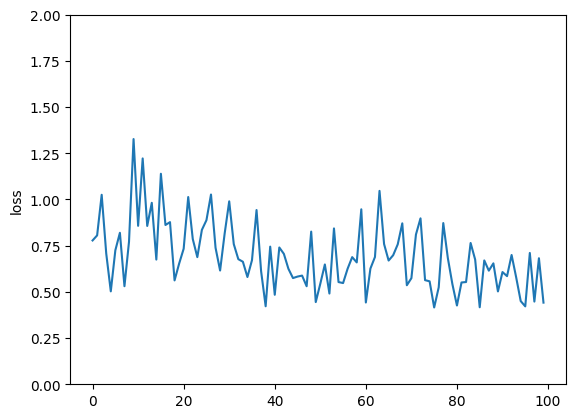

In [ ]:
plt.plot(loss_run)
plt.ylim([0, 2])
plt.ylabel('loss')

In [ ]:
model.eval();

In [ ]:
leData_test = LEDataset(annot_path='./dataset/rcnn/LE_test.txt',
                   transform=transform)

data_loader_test = torch.utils.data.DataLoader(leData_test, batch_size=4, shuffle=True,
                                          collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
imgs, targets = next(iter(data_loader))

In [ ]:
preds = model(imgs, )

In [ ]:
preds[0]['labels']

tensor([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 2, 1, 2], device='cuda:0')

In [ ]:
preds[0]['scores']

tensor([0.9975, 0.9946, 0.5740, 0.5521, 0.5332, 0.5194, 0.5107, 0.5075, 0.5032,
        0.4403, 0.4289, 0.4280, 0.3794, 0.3753, 0.3695, 0.3601, 0.3588, 0.3526,
        0.3453, 0.3247, 0.3220, 0.3158, 0.3135, 0.3034, 0.2883, 0.2846, 0.2832,
        0.2805, 0.2767, 0.2759, 0.2652, 0.2643, 0.2458, 0.2438, 0.2420, 0.2384,
        0.2383, 0.2300, 0.2187, 0.2148, 0.2092, 0.2067, 0.2038, 0.2031, 0.2015,
        0.1996, 0.1995, 0.1940, 0.1936, 0.1879, 0.1863, 0.1847, 0.1836, 0.1829,
        0.1807, 0.1789, 0.1723, 0.1696, 0.1694, 0.1689, 0.1674, 0.1650, 0.1639,
        0.1621, 0.1621, 0.1618, 0.1617, 0.1544, 0.1533, 0.1529, 0.1528, 0.1526,
        0.1521, 0.1519, 0.1507, 0.1492, 0.1487, 0.1482, 0.1477, 0.1473, 0.1470,
        0.1468, 0.1451, 0.1447, 0.1427, 0.1426, 0.1413, 0.1389, 0.1380, 0.1377,
        0.1362, 0.1355, 0.1351, 0.1343, 0.1336, 0.1330, 0.1327, 0.1325, 0.1300,
        0.1296], device='cuda:0', grad_fn=<IndexBackward0>)

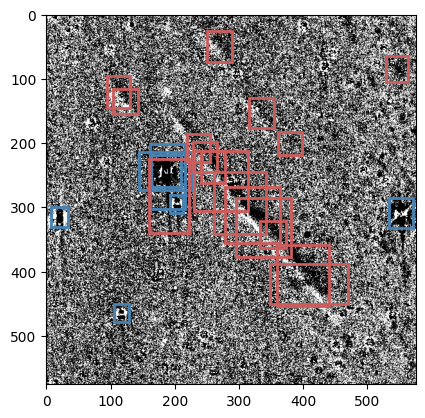

In [ ]:
fig, ax = plt.subplots(1, 1)

idx = 1

img = imgs[idx].cpu().numpy();
pred = preds[idx]

ax.imshow(img[0, :,:], cmap='gray', )
for i in range(len(pred['labels'])):
    xmin, ymin, xmax, ymax = pred['boxes'][i].detach().cpu().numpy()
    label = int(pred['labels'][i].cpu())
    score = float(pred['scores'][i].cpu())
    if score>0.5:
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                        fill=False, color=Colors[label], linewidth=2)

        ax.add_patch(rect)


Exercise: how would you define a true positive detection? make a plot of number of TPs/FPs vs score

In [ ]:
#